<a href="https://colab.research.google.com/github/knyati/text_summarizer/blob/master/Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Summarizer { display-mode: "form" }

In [0]:
!git clone https://github.com/thushv89/attention_keras.git

Cloning into 'attention_keras'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 116 (delta 4), reused 0 (delta 0), pack-reused 102
Receiving objects: 100% (116/116), 193.09 KiB | 1.62 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [0]:
from google.colab import drive

drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from attention_keras.layers import attention

In [0]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import re

Using TensorFlow backend.


In [0]:
import nltk
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
print(stopWords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'between', "weren't", 'your', 'o', 'himself', 'do', "aren't", 'doesn', 'should', 'not', 'be', "you've", 'a', 'hadn', 'this', 'under', 'haven', "you're", 'then', 'having', 'now', "you'd", 'my', 'only', 'because', 'again', 'won', 'are', "that'll", 'to', 'some', 'can', 'in', 'after', 'below', "haven't", 'does', 'itself', 'you', 'such', 'shouldn', 'of', 'd', 'we', 'aren', 'above', 'few', 'wouldn', 'but', 'herself', 'she', 'ours', 'ourselves', 'the', 'for', 'yourself', 'through', 'was', 't', 'theirs', 'were', 'out', 'any', "hadn't", 'if', 'don', 'll', 'will', 'there', "won't", 'on', 'hasn', 'how', 'mightn', 're', "mustn't", 'her', 'being', 'as', 'him', 'whom', 'same', 'mustn', "she's", 's', 'down', 'once', 'is', 'needn', 'his', 'y', 'he', 'nor', 'they', 'when', 'shan', 'me', 'no', 'other', "it's", 'its', 'or', 'where', 'an', 'by', 'wasn', 'off', 'these', 'hers', "mightn't", "would

In [0]:
data = pd.read_csv('/content/gdrive/My Drive/amazon_food_reviews/Reviews.csv',nrows=100000)

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
Id                        100000 non-null int64
ProductId                 100000 non-null object
UserId                    100000 non-null object
ProfileName               99996 non-null object
HelpfulnessNumerator      100000 non-null int64
HelpfulnessDenominator    100000 non-null int64
Score                     100000 non-null int64
Time                      100000 non-null int64
Summary                   99998 non-null object
Text                      100000 non-null object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [0]:
pd.set_option("display.max_colwidth", 200)
data[pd.notnull(data["Summary"])].head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [0]:
dup = data[data.duplicated(['Text'])]

In [0]:
dup

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind! We picked up a bottle once on a trip we wer..."
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so when I opened my first bag of Sea Salt & Vinegar Kettle Brand chips I knew I had a perfect complement to my vegetable trays of cucumber, carrot, celery ..."
603,604,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,1,1,5,1229385600,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so when I opened my first bag of Sea Salt & Vinegar Kettle Brand chips I knew I had a perfect complement to my vegetable trays of cucumber, carrot, celery ..."
1973,1974,B0017165OG,A2EPNS38TTLZYN,tedebear,0,0,3,1312675200,Pok Chops,The pork chops from Omaha Steaks were very tasty but at the same time exceptionally dry. Pork is usually dry meat but these were to the extreme. Possibly shipping them frozen and keeping them froz...
2309,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel making the product overly bitter and diluting the real good taste of the orange zest.
...,...,...,...,...,...,...,...,...,...,...
99710,99711,B002OFU84M,A2QKQWI57N451S,Judi Semel,0,1,2,1245196800,sweet mcnuggets,these are good but verrry sweet.... they taste kind of chinese sweet bbq sauce... high protein
99711,99712,B002OFU84M,AFNTQUTDPMR74,"Stanley M. Dolan ""Drunkenlout""",0,6,3,1223251200,Just OK,They have a funky flavour and really get all over you fingers. I bought these to eat while driving it it isn't going to work.
99772,99773,B001O2IX3Y,ATIHDHZYNQ0EI,"Kristen O'donnell ""twinsmom""",0,0,5,1270425600,Organic and Tasty!,I'd continue to buy but I'm moving over to more home made finger foods and away from glass jars...shattered too many. They like all the flavors though. Great textures too.
99778,99779,B001O2IX3Y,A298EGEB1PX9EH,S. Smith,0,1,1,1276646400,poorly packaged,Several broke during transit causing mold to grow over all the other jars. Jars are cheaper at Walmart.


In [0]:
data.drop_duplicates(subset=['Text'],keep='first',inplace=True)
data.dropna(axis=0,inplace=True)

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [0]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [0]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [0]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [0]:
data['cleaned_summary']

0                                                        good quality dog food 
1                                                            not as advertised 
2                                                          delight says it all 
3                                                               cough medicine 
4                                                                  great taffy 
                                          ...                                  
99995                                                                    yummy 
99996                                                         tastes like more 
99997                                                              great ramen 
99998                                                                    spicy 
99999    this spicy noodle cures my cold upset stomach and headache every time 
Name: cleaned_summary, Length: 88352, dtype: object

In [0]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

Distribution analysis

In [0]:
import matplotlib.pyplot as plt
text_count = []
summary_count = []

data['cleaned_text'].apply(lambda x: text_count.append(len(x.split())))
data['cleaned_summary'].apply(lambda x: summary_count.append(len(x.split())))

0        None
1        None
2        None
3        None
4        None
         ... 
99995    None
99996    None
99997    None
99998    None
99999    None
Name: cleaned_summary, Length: 88352, dtype: object

In [0]:
data = data.drop(columns=['Text','Summary'])

In [0]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,cleaned_text,cleaned_summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,_START_ good quality dog food _END_
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,_START_ not as advertised _END_
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,_START_ delight says it all _END_
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,_START_ cough medicine _END_
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,_START_ great taffy _END_


In [0]:
print(len(text_count))
print(text_count[55])

88352
18


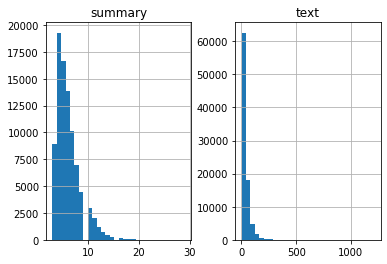

In [0]:
length_df = pd.DataFrame({'text':text_count, 'summary':summary_count})
length_df.hist(bins = 30)
plt.show()

In [0]:
max_len_text=80 
max_len_summary=10

In [0]:
length_df.text.describe()

count    88352.000000
mean        38.459944
std         36.316703
min          2.000000
25%         17.000000
50%         27.000000
75%         47.000000
max       1212.000000
Name: text, dtype: float64

In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [0]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [0]:
x_tr.shape

(79516, 80)

In [0]:
y_voc_size

14096

Model Initialization

In [0]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 
 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = attention.AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model = Model([encoder_inputs,decoder_inputs],decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      25785500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min')

In [0]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

In [0]:
history=model.fit([x_tr,y_tr], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1),epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)))

Train on 79516 samples, validate on 8836 samples
Epoch 1/50
79516/79516 [==============================] - 237s 3ms/sample - loss: 0.3930 - val_loss: 0.1858
Epoch 2/50
79516/79516 [==============================] - 237s 3ms/sample - loss: 0.1878 - val_loss: 0.0964
Epoch 3/50
79516/79516 [==============================] - 236s 3ms/sample - loss: 0.1052 - val_loss: 0.0626
Epoch 4/50
79516/79516 [==============================] - 238s 3ms/sample - loss: 0.0594 - val_loss: 0.0479
Epoch 5/50
79516/79516 [==============================] - 234s 3ms/sample - loss: 0.0491 - val_loss: 0.0410
Epoch 6/50
79488/79516 [============================>.] - ETA: 0s - loss: 0.0161

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='training_loss')
plt.plot(history.history['val_loss'],label='vali_loss')
plt.legend()
plt.show()

array([   1, 7582, 1967, 1315,  568,    2,    0,    0,    0,    0],
      dtype=int32)

In [0]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

array([7582, 1967, 1315,  568,    2,    0,    0,    0,    0], dtype=int32)

In [0]:
encoder_model = Model(encoder_inputs,[encoder_outputs,state_h,state_c])

#decoder
decoder_state_input_h = Input(shape = (latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2,state_h2,state_c2 = decoder_lstm(dec_emb2,initial_state=[decoder_state_input_c,decoder_state_input_h])

decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input,decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1,name='concat')([decoder_outputs2,attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2,state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
       # print(sampled_token_index)
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

In [0]:
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [0]:
for i in range(20):
  print("Review:",seq2text(x_tr[i]))
  print("Original summary:",seq2summary(y_tr[i]))
  print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_text)))
  print("\n")